<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/SVM/DeBERTa2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

In [3]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

# gptModel = 'raygx/GPT-NepSA-T2' ## Fine-tuned Model ## 'raygx/Nepali-GPT2-CausalLM' ## Pre-Trained LM ##
# gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
# gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'raygx/DeBERTa-NepCov19SA' ## Fine-tuned DeBERTa model for SA ##'raygx/BERT-NepSA-T2' ## Fine-tuned Model for SA ## 'raygx/BertClassifier4NepaliNews' ## Fine-tuned Model for NewsClassification ## 'Shushant/nepaliBERT' ## Pre-Trained LM ##
try:
  bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
except:
  bertTokenizer = PreTrainedTokenizerFast.from_pretrained(bertModel)

try:
  bertModel = TFAutoModel.from_pretrained(bertModel)#,revision='3d8fa5f1a60104bad4592461a0237b85b9c8756c')
except:
  bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

bertModel = bertModel.deberta
bertModel.config

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'BertTokenizerFast'.
Some layers from the model checkpoint at raygx/DeBERTa-NepCov19SA were not used when initializing TFDebertaModel: ['pooler', 'cls_dropout', 'classifier']
- This IS expected if you are initializing TFDebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDebertaModel were initialized from the model checkpoint at ray

DebertaConfig {
  "_name_or_path": "raygx/DeBERTa-NepCov19SA",
  "architectures": [
    "DebertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "type_vocab_size": 0,
  "vocab_size": 24581
}

In [4]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [5]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [6]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [17]:
import tensorflow as tf

# class GPTEmbedding(tf.keras.layers.Layer):
#   def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
#     super().__init__()
#     self.embedding = model
#     self.tokenizer = tokenizer
#     self.tokenizer.padding_side = 'left'
#     self.max_token = max_token_len
#     self.padding = padding
#     self.truncation = truncation
#     self.trailing_context = trailing_context
#     self.trainable=False

#   def call(self, x):
#     embeddings = self.embedding(
#                   self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
#                 )[0][:,-self.trailing_context:,:]

#     return tf.reduce_logsumexp(embeddings,axis=1)

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    return self.embedding(
        self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
        )['last_hidden_state'][:,:1,:]

### Preparing Training Data

In [18]:
from tqdm.auto import tqdm

# gptEmbd = GPTEmbedding(model=gptModel,tokenizer=gptTokenizer,trailing_context=4,max_token_len=100)
bertEmbd = BERTEmbedding(model=bertModel,tokenizer=bertTokenizer,max_token_len=100)

X = None
batch = 16
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat = bertEmbd(data['train'][i:i+batch]['text'])

    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X = tf.reshape(X,(X.shape[0],X.shape[-1]))
X.shape

  0%|          | 0/2077 [00:00<?, ?it/s]

(33232, 1, 768)

In [23]:
### Attention Visualization
# import seaborn as sns

# output = bertModel(bertTokenizer(data['train'][:1]['text'],return_tensors='tf'),output_attentions=True)
# print(output.keys())
# print(output['attentions'][1].shape)

### output['attentions'][nLayer][nBatch][nHead]
# sns.heatmap(output['attentions'][-2][0][-6])

## Training

In [24]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 6min 47s, sys: 938 ms, total: 6min 47s
Wall time: 7min 18s


array([0, 1, 2])

### Preparing Test Data

In [25]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat = bertEmbd(data['test'][i:i+batch]['text'])

    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

testX = tf.reshape(testX,(testX.shape[0],testX.shape[-1]))

  0%|          | 0/520 [00:00<?, ?it/s]

## Evaluation

In [26]:
%%time
predictions = clf.predict(testX)

CPU times: user 1min 55s, sys: 226 ms, total: 1min 55s
Wall time: 1min 55s


In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.806378504644262
Precision-Score 0.8138720717633248
Recall-Score 0.8063545553014804
accuracy_Score 0.8063545553014804


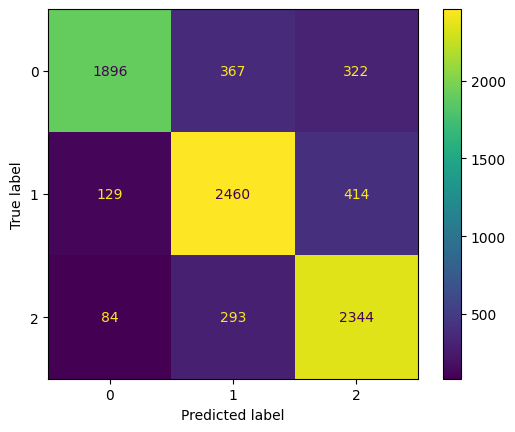

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()